In [1]:
import argparse
import os
import sys
from pathlib import Path
import numpy as np

import torch

#ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

from models.common import DetectMultiBackend
from utils.dataloaders import LoadImage
from utils.general import (check_img_size, Profile, check_requirements, non_max_suppression, print_args, scale_boxes)
from utils.plots import Annotator, colors
from utils.torch_utils import select_device, smart_inference_mode

conf_thres=0.25,  # confidence threshold
iou_thres=0.45,  # NMS IOU threshold
max_det=1000,  # maximum detections per image
classes=None,  # filter by class: --class 0, or --class 0 2 3
agnostic_nms=False,  # class-agnostic NMS
line_thickness=1

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
weights = 'C:/Users/robertzsolt/Downloads/best.pt'

model = DetectMultiBackend(weights, device=device)
names = model.names

Fusing layers... 
Model summary: 157 layers, 7031701 parameters, 0 gradients


In [3]:
from matplotlib import pyplot as plt
import cv2 as cv
from PIL import Image
test_img_path = f"C:/Data/Lung/Images/SCN1/SCN1_0000.png"
test_image = Image.open(test_img_path).convert('RGB')
#test_image = np.transpose(np.array(test_image),(2,0,1))
test_image = np.array(test_image)
test_image.shape

(512, 512, 3)

In [4]:
im = test_image.copy()
print(im.shape)
im = torch.from_numpy(im).permute(2,0,1).to(model.device)
im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
im /= 255  # 0 - 255 to 0.0 - 1.0
if len(im.shape) == 3:
    im = im[None]  # expand for batch dim

pred = model(im, visualize=False)

pred = non_max_suppression(pred)

(512, 512, 3)


In [5]:
for det in pred:  # per image
    im0 = np.ascontiguousarray(test_image.copy())

    annotator = Annotator(im0, line_width=line_thickness, example=str(names))
    if len(det):
        # Rescale boxes from img_size to im0 size
        det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()

        # Write results
        for *xyxy, conf, cls in reversed(det):
            c = int(cls)  # integer class
            label = (f'{names[c]} {conf:.2f}')
            annotator.box_label(xyxy, label, color=colors(c, True))



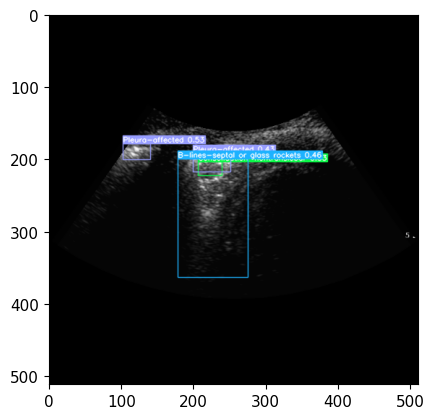

In [64]:
%matplotlib inline
imgplot = plt.imshow(im0)
plt.show()

In [38]:
def predict_test(im0s):
    #model.warmup(imgsz=(1 if pt or model.triton else bs, 3, *imgsz))  # warmup
    im = im0s.copy()

    im = torch.from_numpy(im).to(model.device)
    im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
    im /= 255  # 0 - 255 to 0.0 - 1.0
    if len(im.shape) == 3:
        im = im[None]  # expand for batch dim

    # Inference
    visualize = False
    pred = model(im, visualize=visualize)

    # NMS
    pred = non_max_suppression(pred)

    # Process predictions
    for det in pred:  # per image
        im0 = im0s.copy()

        annotator = Annotator(im0, line_width=line_thickness, example=str(names))
        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()

            # Write results
            for *xyxy, conf, cls in reversed(det):
                c = int(cls)  # integer class
                label = (f'{names[c]} {conf:.2f}')
                annotator.box_label(xyxy, label, color=colors(c, True))

    return im0

In [70]:
from yolov5 import YOLOv5
model_folder = f"C:/Canada/Networks/YOLOv5/dummyRun"

yolo_model = YOLOv5()
yolo_model.loadModel(model_folder, "testModel")

Fusing layers... 
Model summary: 157 layers, 7031701 parameters, 0 gradients


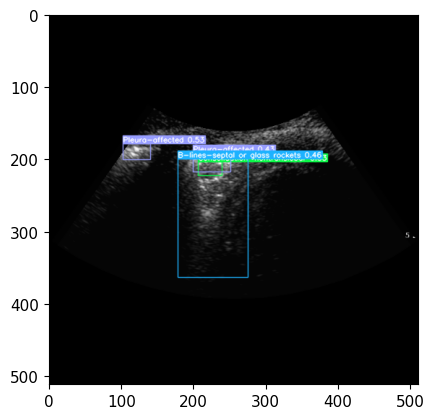

In [71]:
test_pred = yolo_model.predict(test_image)
%matplotlib inline
imgplot = plt.imshow(im0)
plt.show()